In [1]:
import copy
import time

from PIL import Image
import numpy as np
import tqdm

from utils import open_convert_img, precompute_verteces, calculate_f_step_0, calculate_f_next

In [2]:
image_path1 = "./cones/im2.png"
image_path2 = "./cones/im6.png"
# read images
img1 = open_convert_img(image_path1)
img2 = open_convert_img(image_path2)
print("Shape of image1 : ",img1.shape)
print("Shape of image2 : ",img2.shape)
D = np.arange(50)
print("D : ", D)
print("image_width : ", img1.shape[1])
print("image_height : ", img1.shape[0])

Shape of image1 :  (375, 450)
Shape of image2 :  (375, 450)
D :  [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49]
image_width :  450
image_height :  375


In [7]:
line_left = img1
line_right = img2
verteces = precompute_verteces(D)
start_time = time.time()
for i in tqdm.tqdm(range(0,img1.shape[1])):
    if i == 0:
        f_current, s_current = calculate_f_step_0(D,line_left,line_right, img1.shape[0])
    else :
        f_current, s_current  = calculate_f_next(index_next=i,
                                                 set_D=D,
                                                 n_columns=img1.shape[0],
                                                 s_previous_array = s_current,
                                                 f_previous_array = f_current,
                                                 image_left = line_left,
                                                 image_right = line_right,
                                                 verteces = verteces)
end_time = time.time()
print("elapsed time : ", end_time - start_time)

100%|██████████| 450/450 [00:23<00:00, 19.23it/s]


elapsed time :  23.412887811660767


In [11]:
argmins = f_current.argmin(axis=1)
final_img = list()
for i in range(0,img1.shape[0]):
    final_img.append(list(s_current[i,argmins[i],:]))

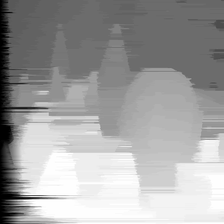

In [12]:
max_value = max(max(final_img))
Image.fromarray(np.uint8((np.array(final_img)/max_value)*254)).resize((224,224), Image.ANTIALIAS)